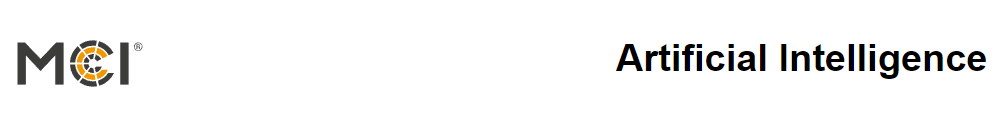

---

# 02 c Data Augmentation for Signals with TSAUG

This jupyter notebook highly relies on the introduction of tsaug [here](https://tsaug.readthedocs.io/en/stable/quickstart.html).

### 0.1 A proper time series processing library

There are several libraries out there that can be used for time series processing (e.g. [tsaug](https://tsaug.readthedocs.io/en/stable/), [TSGM](https://tsgm.readthedocs.io/en/latest/) or [tsai](https://timeseriesai.github.io/tsai/)). The focus will be on tsaug here. 

### 1.1 The Problem

A golf club interacts with the golf ball only for a very short period of time. Needless to say, that this interaction has a strong impact on the trajectory of the golf ball. To get the best out of a swing it is necessary to hit the ball with the golf club in the right way. Most golf clubs have a sweet spot on the golf clubs head, which is optimal for impulse transfer onto the ball. To measure how far off an athlete is with his or her hit is of relevance for training. Therefore, an IMU was placed on the golf clubs shaft and the horizontal offset was measured and categorized in an experiment. Now we need to see if we can connect the signals from the IMU with the categories as shown below.

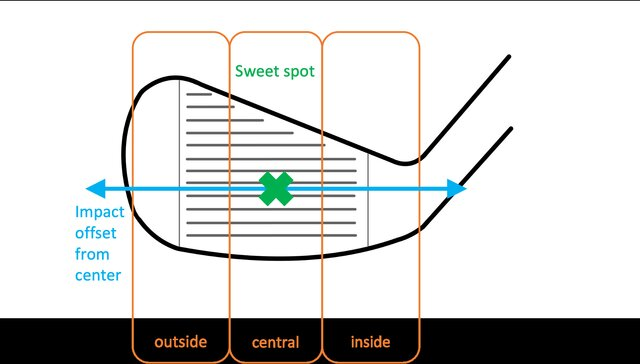

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


### 1.2 Data Aquisition

As we have imported all libraries, we can now have a look on the data. Therefore, we define the paths to our dataset

In [2]:
path="../Data/Golfball_Impact"

Now we want load the data. To make it easy we define a function that does it for us. As we are using tsaug, we want the data to be in a numpy array structure

In [3]:
def read_csv(data_file_path,num_of_cols_to_be_read):
    read_file = pd.read_csv(data_file_path, delimiter=";")
    read_file=np.array(read_file)
    if num_of_cols_to_be_read==9:
      AccX=read_file[:,0]
      AccY=read_file[:,1]
      AccZ=read_file[:,2]
      GyrX=read_file[:,3]
      GyrY=read_file[:,4]
      GyrZ=read_file[:,5]
      MagX=read_file[:,6]
      MagY=read_file[:,7]
      MagZ=read_file[:,8]
      poi=read_file[:,9]



      return np.array([AccX,AccY,AccZ,GyrX,GyrY,GyrZ,MagX,MagY,MagZ,poi])

    elif num_of_cols_to_be_read==6:
      AccX=read_file[:,0]
      AccY=read_file[:,1]
      AccZ=read_file[:,2]
      GyrX=(read_file[:,3])
      GyrY=(read_file[:,4])
      GyrZ=(read_file[:,5])
      poi=read_file[:,9]


      return np.array([AccX,AccY,AccZ,GyrX,GyrY,GyrZ,poi])

    else:
      AccX=read_file[:,0]
      AccY=read_file[:,1]
      AccZ=read_file[:,2]
      poi=read_file[:,9]

      return np.array([AccX,AccY,AccZ,poi])

Now we can use the function to load the data.

In [4]:
# Define configuration
entries = os.listdir(path)
number_of_steps=400
num_of_input_signals = 3

# allocate the np arrays
X_data=np.empty([len(entries),number_of_steps,num_of_input_signals])
Y_data=np.empty([len(entries),1])
poi=np.empty([len(entries),2])
marker=np.empty(len(entries))
maxima=np.zeros((1,9))
minima=np.zeros((1,9))

counter=0
for file in entries:
    inputdata=read_csv(path+'/'+file,num_of_input_signals)
    X_data[counter,:,:]=np.transpose(inputdata[0:num_of_input_signals,0:number_of_steps])
    Y_data[counter]=inputdata[num_of_input_signals,0]
    poi[counter,:]=inputdata[num_of_input_signals,0:2]
    counter=counter+1

Now we can check, how the data was structured:

In [5]:
print("The shape of X_data is " + str(X_data.shape))
print("The shape of Y_data is " + str(Y_data.shape))

The shape of X_data is (494, 400, 3)
The shape of Y_data is (494, 1)


The shape of X_data is (494, 400, 3), with 494 samples, 400 steps in time and 3 signals.
The shape of Y_data is (494, 1), with 494 samples and 1 output.

To get a better idea what the data looks like, we can plot the first three signals of X_data

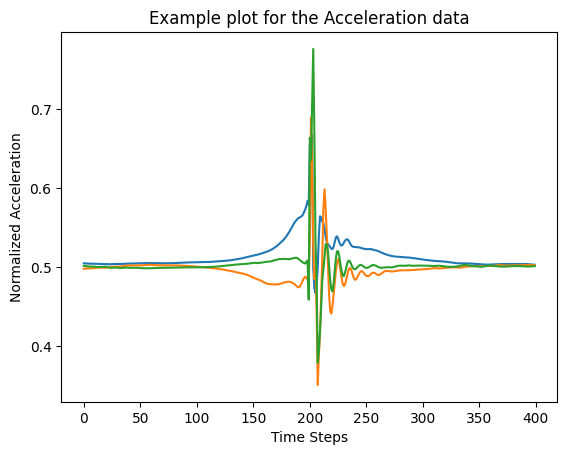

In [10]:
plt.plot(X_data[0, :, 0]) # Plot the first element of X_data
plt.plot(X_data[0, :, 1]) # Plot the second element of X_data
plt.plot(X_data[0, :, 2]) # Plot the third element of X_data
plt.xlabel("Time Steps")
plt.ylabel("Normalized Acceleration")
plt.title("Example plot for the Acceleration data")
plt.show()


The singals seem already transformed. with a Min-Max-Scaler into the range 0 to 1

In [6]:
for i in range(3):
  print("Maximum in singal " + str(i) + " is " + str(np.max(X_data[:,:,i])))
  print("Minimum in singal " + str(i) + " is " + str(np.min(X_data[:,:,i])))

Maximum in singal 0 is 0.8303125
Minimum in singal 0 is 0.2028125
Maximum in singal 1 is 0.99
Minimum in singal 1 is 0.0159375
Maximum in singal 2 is 1.0
Minimum in singal 2 is 0.059375


The output y_data can be seen as follows

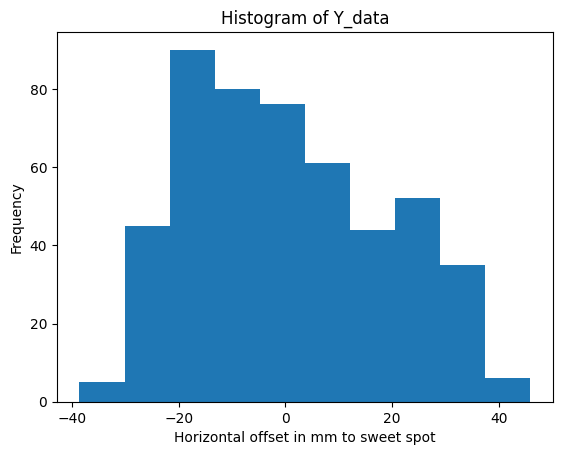

In [7]:
plt.hist(Y_data)
plt.xlabel("Horizontal offset in mm to sweet spot")
plt.ylabel("Frequency")
plt.title("Histogram of Y_data")
plt.show()


Y_data is not normalized as can be seen in the histogram. As we want the output to be categories, is is irrelevant at the moment, since we categorize it later.

To get a better idea of the output data, here is the point of interaction between golf ball and club head face (including the category/class)

[Text(0.5, 0, 'horizontal offset / mm'), Text(0, 0.5, 'vertical offset / mm')]

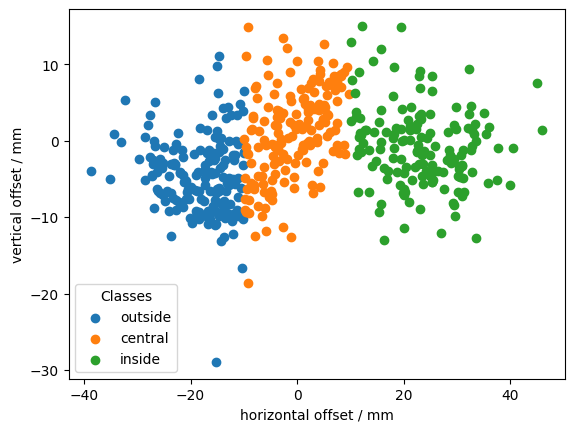

In [8]:
fig, ax = plt.subplots()
outsideclasses=poi[poi[:,0]<-10]
centralclasses=poi[poi[:,0]>=-10]
centralclasses=centralclasses[centralclasses[:,0]<=10]
insideclasses=poi[poi[:,0]>10]
out=ax.scatter(outsideclasses[:,0],outsideclasses[:,1],label='outside')
cen=ax.scatter(centralclasses[:,0],centralclasses[:,1],label='central')
ins=ax.scatter(insideclasses[:,0],insideclasses[:,1],label='inside')
legend1 = ax.legend(handles=[out,cen,ins],loc="lower left", title="Classes")
ax.set(xlabel='horizontal offset / mm', ylabel='vertical offset / mm',)

If we want to have the output as category, we can easily create a new numpy array, that categorizes Y_data. We choose $\pm 10$ mm around the sweet spot as central class, the other two classes are either outside or inside.

(494, 1)


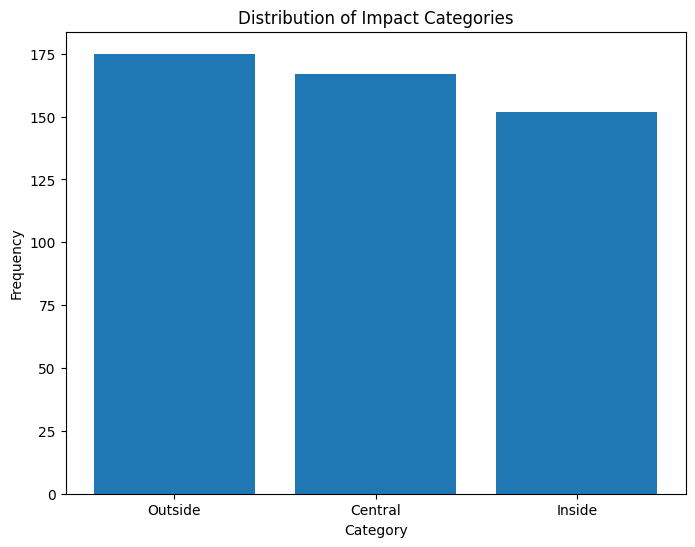

In [9]:
categories = np.zeros(poi.shape[0])
categories[(poi[:, 0] >= -10) & (poi[:, 0] <= 10)] = 1
categories[poi[:, 0] > 10] = 2

y_category=categories.reshape(-1,1)
print(y_category.shape)

category_counts = np.bincount(categories.astype(int))

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(['Outside', 'Central', 'Inside'], category_counts)
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Distribution of Impact Categories')
plt.show()


## 1.3 Augmentation

As shown before, the data has nearly 500 samples (instances). If we devide it in three classes, we approximately have 166 each. So Augmentation could be of interest.

#### TASK: Which augmentation methods would be reasonable?

your answers go here

Reasonable answers could be:


*   Noise
*   Averaging
*   Time-Warp (maybe)


### 1.3.1. Adding Noise

Adding noise can help to achieve better results form the generalization of your algorithm. At the same time, it can help to prevent overfitting. To be able to perform a noise augmentation, we can use tsaug.

In [10]:
import tsaug

X_data_augmented_add_noise=np.empty_like(X_data)

for index1 in range(X_data.shape[0]):
  X_data_augmented_add_noise[index1,:,:] = tsaug.AddNoise(scale=np.random.rand()*0.01).augment(X_data[index1,:,:])

y_category_augmented_add_noise=y_category.copy()

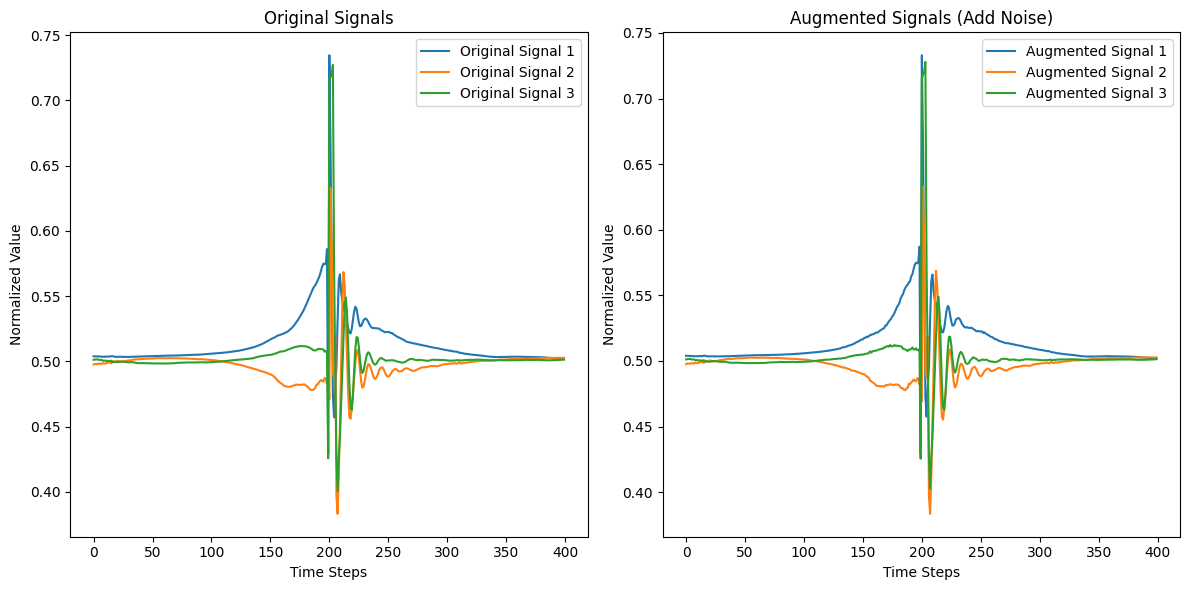

In [11]:
# Plot the original and augmented signals
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(X_data[0, :, 0], label='Original Signal 1')
plt.plot(X_data[0, :, 1], label='Original Signal 2')
plt.plot(X_data[0, :, 2], label='Original Signal 3')
plt.xlabel("Time Steps")
plt.ylabel("Normalized Value")
plt.title("Original Signals")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X_data_augmented_add_noise[0, :, 0], label='Augmented Signal 1')
plt.plot(X_data_augmented_add_noise[0, :, 1], label='Augmented Signal 2')
plt.plot(X_data_augmented_add_noise[0, :, 2], label='Augmented Signal 3')
plt.xlabel("Time Steps")
plt.ylabel("Normalized Value")
plt.title("Augmented Signals (Add Noise)")
plt.legend()

plt.tight_layout()
plt.show()


### 1.3.2. Averaging

Averaging could be reasonable. Especially if we try to average within the given classes. Therefore try to augment the data within the classes to create new data. The first steo is to create class specific numpy arrays.

#### TASK: do the averaging augmentation. Make 150 augmented samples of each class

In [12]:
# your code goes here

 Be aware, that you should be able to complete the task on your own.

If you need support, here is the solution to the TASK.

In [13]:
X_data_outside = X_data[y_category[:,0] == 0]
X_data_central = X_data[y_category[:,0] == 1]
X_data_inside = X_data[y_category[:,0] == 2]
y_category_outside = y_category[y_category[:,0] == 0]
y_category_central = y_category[y_category[:,0] == 1]
y_category_inside = y_category[y_category[:,0] == 2]
y_category_central=y_category_central.reshape(-1,1)
y_category_outside=y_category_outside.reshape(-1,1)
y_category_inside=y_category_inside.reshape(-1,1)

print("Shape of X_data_outside:", X_data_outside.shape)
print("Shape of X_data_central:", X_data_central.shape)
print("Shape of X_data_inside:", X_data_inside.shape)
print("Shape of y_category_outside:", y_category_outside.shape)
print("Shape of y_category_central:", y_category_central.shape)
print("Shape of y_category_inside:", y_category_inside.shape)


Shape of X_data_outside: (175, 400, 3)
Shape of X_data_central: (167, 400, 3)
Shape of X_data_inside: (152, 400, 3)
Shape of y_category_outside: (175, 1)
Shape of y_category_central: (167, 1)
Shape of y_category_inside: (152, 1)


Now we need the averaging augmentation function.

In [14]:
def averaging_augmentation(X_data, y_category, number_of_augmentations=1):
    augmented_data = []
    augmented_labels = []

    for _ in range(number_of_augmentations):
        # Randomly select two rows
        indices = np.random.choice(X_data.shape[0], 2, replace=False)
        row1 = X_data[indices[0],:,:]
        row2 = X_data[indices[1],:,:]

        # Apply random weights
        weight1 = np.random.rand()
        weight2 = 1-weight1

        # Multiply and sum
        new_row = weight1 * row1 + weight2 * row2

        augmented_data.append(new_row)
        augmented_labels.append(y_category[indices[0]]) # Use label from first row

    return np.array(augmented_data), np.array(augmented_labels)

Now we need to apply the function to the data

In [15]:
number_of_augmentations = 150  # Adjust as needed
X_outside_augmented, y_outside_augmented = averaging_augmentation(X_data_outside, y_category_outside, number_of_augmentations)
X_central_augmented, y_central_augmented = averaging_augmentation(X_data_central, y_category_central, number_of_augmentations)
X_inside_augmented, y_inside_augmented = averaging_augmentation(X_data_inside, y_category_inside, number_of_augmentations)

print("Shape of augmented data:", X_outside_augmented.shape)
print("Shape of augmented labels:", y_outside_augmented.shape)
print("Shape of augmented data:", X_central_augmented.shape)
print("Shape of augmented labels:", y_central_augmented.shape)
print("Shape of augmented data:", X_inside_augmented.shape)
print("Shape of augmented labels:", y_inside_augmented.shape)

Shape of augmented data: (150, 400, 3)
Shape of augmented labels: (150, 1)
Shape of augmented data: (150, 400, 3)
Shape of augmented labels: (150, 1)
Shape of augmented data: (150, 400, 3)
Shape of augmented labels: (150, 1)


### 1.3.3. Making a Timewarp

Timewarping can be seen as changing the speed of the timeline locally. As always we try to visualize the augmentations, so it is easy to grasp.

In [16]:
X_data_augmented_timewarp=np.empty_like(X_data)

for index1 in range(X_data.shape[0]):
  X_data_augmented_timewarp[index1,:,:] = tsaug.TimeWarp(n_speed_change=3, max_speed_ratio=1.05,seed=42).augment(X_data[index1,:,:])

y_category_augmented_timewarp=y_category.copy()

print("Shape of augmented data:", X_data_augmented_timewarp.shape)
print("Shape of augmented labels:", y_category_augmented_timewarp.shape)

Shape of augmented data: (494, 400, 3)
Shape of augmented labels: (494, 1)


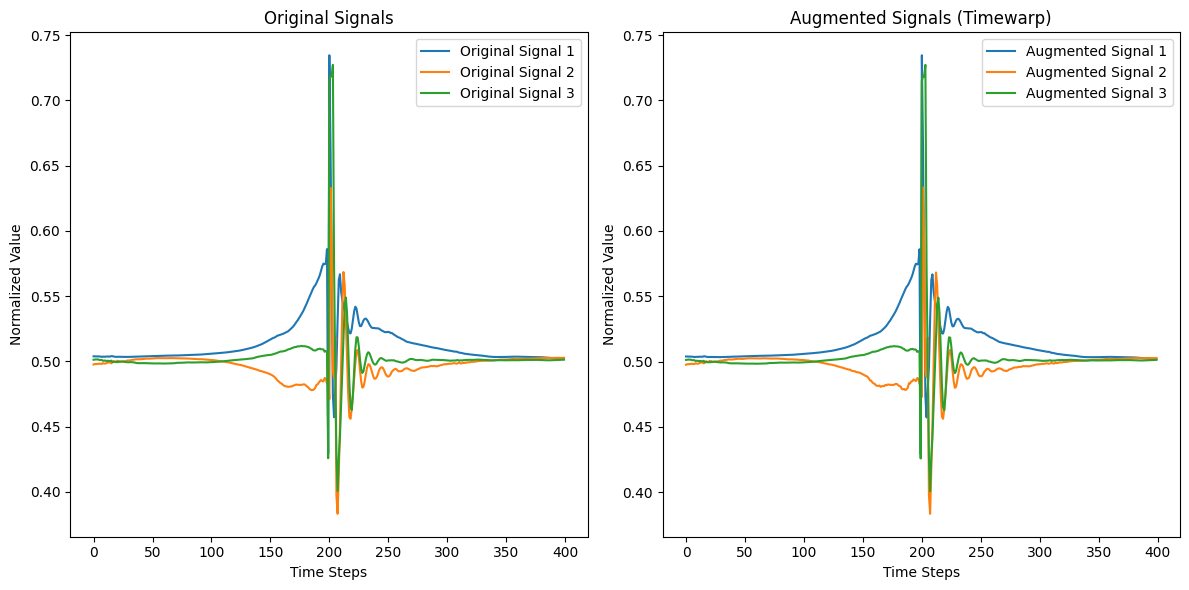

In [17]:
# Plot the original and augmented signals
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(X_data[0, :, 0], label='Original Signal 1')
plt.plot(X_data[0, :, 1], label='Original Signal 2')
plt.plot(X_data[0, :, 2], label='Original Signal 3')
plt.xlabel("Time Steps")
plt.ylabel("Normalized Value")
plt.title("Original Signals")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X_data_augmented_timewarp[0, :, 0], label='Augmented Signal 1')
plt.plot(X_data_augmented_timewarp[0, :, 1], label='Augmented Signal 2')
plt.plot(X_data_augmented_timewarp[0, :, 2], label='Augmented Signal 3')
plt.xlabel("Time Steps")
plt.ylabel("Normalized Value")
plt.title("Augmented Signals (Timewarp)")
plt.legend()

plt.tight_layout()
plt.show()

### 1.3.4. Summarize and analyze the data

We have used several augmentation methods. Now it is time to summarize the data and create a dataset.

#### TASK: Summarize the dataset to one numpy array / dataframe

In [18]:
# your code goes here

 Be aware, that you should be able to complete the task on your own.

If you need support, here is the solution to the TASK.

In [19]:
X_data_combined = np.vstack((X_data, X_data_augmented_timewarp, X_data_augmented_add_noise, X_central_augmented, X_outside_augmented, X_inside_augmented))
y_category_combined = np.vstack((y_category, y_category_augmented_timewarp, y_category_augmented_add_noise, y_central_augmented, y_outside_augmented, y_inside_augmented))
print("Shape of the combined X data:", X_data_combined.shape)
print("Shape of the combined y data:", y_category_combined.shape)


Shape of the combined X data: (1932, 400, 3)
Shape of the combined y data: (1932, 1)


#### TASK: Analyze the dataset

 Be aware, that you should be able to complete the task on your own.

If you need support, here is a solution to the TASK.

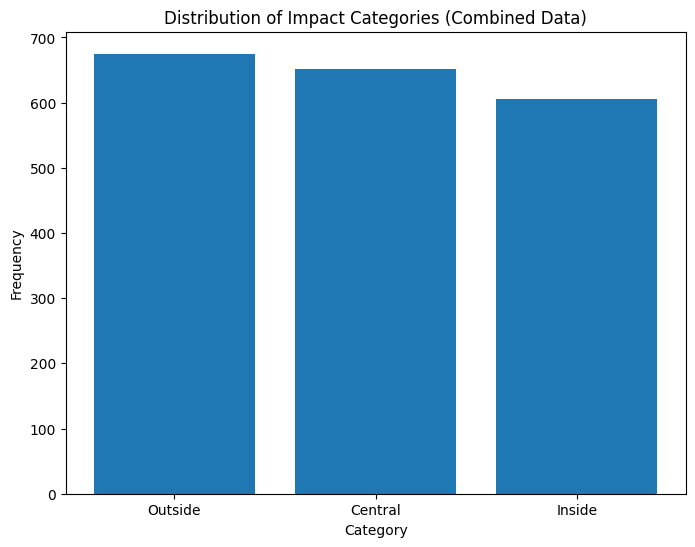

In [21]:
category_counts_combined = np.bincount(y_category_combined.astype(int).flatten())

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(['Outside', 'Central', 'Inside'], category_counts_combined[:3]) #Plot only the first 3 categories
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Distribution of Impact Categories (Combined Data)')
plt.show()
